# Sentiment Analysis on Tweets about Brands and Products


- Names: 
    - Ingavi Kilavuka
    - Calvin Omwega
    - Alvin Kimathi
    - Ronny Kabiru
- Instructor: Maryann Mwikali
- Modeling Focus: NLP(Natural Language Processing)


## Objective


To analyze the sentiment of tweets directed at various brands and products to understand public perception. This will involve determining whether the sentiment expressed in tweets is positive, negative, or neutral and identifying the specific brands and products mentioned.


### Problem Definition

In the age of social media, understanding public sentiment towards brands and products is crucial for businesses. This project aims to:
1. **Identify the Sentiment**: Determine whether the sentiment expressed in each tweet is positive, negative, or neutral.
2. **Target Identification**: Identify the specific brand or product that the sentiment is directed towards.
3. **Trends and Insights**: Derive insights and trends regarding public perception of various brands and products.


Research Questions:
1. **Sentiment Classification**: What is the distribution of positive, negative, and neutral sentiments across the dataset?
2. **Brand/Product Association**: Which brands and products are most frequently mentioned, and what is the associated sentiment for each?
3. **Temporal Trends**: Are there any notable trends in sentiment over time for specific brands or products?

## Data Understanding

In [7]:
# import necessary libraries
import re
import string
import nltk
import pandas as pd
import numpy as np
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, GRU
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
# from scikeras.wrappers import KerasClassifier 

In [8]:
# Load the dataset
df = pd.read_csv('judge_1377884607_tweet_product_company.csv')

In [9]:
df.shape

(8721, 3)

In [10]:
def explore_dataset(df):
    # Display column names
    print("Column Names:")
    print(df.columns.tolist())
    print("\n")

    # Display data types
    print("Data Types:")
    print(df.dtypes)
    print("\n")

    # Display number of rows and columns
    print("Shape of the DataFrame:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\n")

    # DataFrame info
    print("DataFrame Info:")
    df.info()
    print("\n")

    # Descriptive statistics for numerical columns
    print("Descriptive Statistics:")
    print(df.describe())
    print("\n")

    # Missing values summary
    print("Missing Values (Percentage):")
    missing_values_percentage = (df.isnull().sum() / len(df)) * 100
    print(missing_values_percentage)
    print("\n")

    # Display summary statistics for categorical columns
    print("Categorical Data Summary:")
    categorical_summary = df.select_dtypes(include=['object']).describe()
    print(categorical_summary)
    print("\n")

    # Value counts for categorical columns
    print("Value Counts for Categorical Columns:")
    for column in df.select_dtypes(include=['object']).columns:
        print(f"Column: {column}")
        print(df[column].value_counts(dropna=False))
        print("\n")

explore_dataset(df)

Column Names:
['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


Data Types:
tweet_text                                            object
emotion_in_tweet_is_directed_at                       object
is_there_an_emotion_directed_at_a_brand_or_product    object
dtype: object


Shape of the DataFrame:
Rows: 8721, Columns: 3


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


Descriptive Statistics:
                              

## Data Cleaning and Preprocessing

In [11]:
#Drop any rows with missing values
df.dropna(subset=['tweet_text'], inplace=True)
#Drop any duplicate values
df.drop_duplicates(subset=['tweet_text'], inplace=True)


In [12]:
#Removing Urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Apply the function to the tweet column
df['cleaned_text'] = df['tweet_text'].apply(remove_urls)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,@jessedee Know about @fludapp ? Awesome iPad/i...
2,@swonderlin Can not wait for #iPad 2 also. The...,@swonderlin Can not wait for #iPad 2 also. The...
3,@sxsw I hope this year's festival isn't as cra...,@sxsw I hope this year's festival isn't as cra...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,@sxtxstate great stuff on Fri #SXSW: Marissa M...


In [13]:
#Removing special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the cleaned_text column
df['cleaned_text'] = df['cleaned_text'].apply(remove_special_characters)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 I have a 3G iPhone After 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know about fludapp Awesome iPadiPhon...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin Can not wait for iPad 2 also They s...
3,@sxsw I hope this year's festival isn't as cra...,sxsw I hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff on Fri SXSW Marissa Maye...


In [14]:
#Removing Stopwords
# Download stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Apply the function to the cleaned_text column
df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/calvinomwega/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 3G iPhone 3 hrs tweeting RISEAustin d...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know fludapp Awesome iPadiPhone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait iPad 2 also sale SXSW
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope years festival isnt crashy years iPh...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff Fri SXSW Marissa Mayer G...


In [15]:
from nltk.tokenize import word_tokenize

# Download punkt for tokenization
nltk.download('punkt')

def tokenize_text(text):
    return word_tokenize(text)

# Apply the function to the cleaned_text column
df['tokens'] = df['cleaned_text'].apply(tokenize_text)

# Display the first few rows to verify the changes
df[['tweet_text', 'cleaned_text', 'tokens']].head()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calvinomwega/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,tweet_text,cleaned_text,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley83 3G iPhone 3 hrs tweeting RISEAustin d...,"[wesley83, 3G, iPhone, 3, hrs, tweeting, RISEA..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee Know fludapp Awesome iPadiPhone app y...,"[jessedee, Know, fludapp, Awesome, iPadiPhone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait iPad 2 also sale SXSW,"[swonderlin, wait, iPad, 2, also, sale, SXSW]"
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope years festival isnt crashy years iPh...,"[sxsw, hope, years, festival, isnt, crashy, ye..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff Fri SXSW Marissa Mayer G...,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ..."


## Exploratory Data Analysis

### Sentiment Analysis

In [16]:
# Perform sentiment analysis and create a frequency table
def analyze_sentiments_and_plot_frequency(df, tweet_text):
    # Creating a TextBlob object for each tweet and calculate sentiment
    df['sentiment'] = df[tweet_text].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Define sentiment labels
    def get_sentiment_label(sentiment):
        if sentiment > 0:
            return 'Positive'
        elif sentiment < 0:
            return 'Negative'
        else:
            return 'Neutral'
    
    df['sentiment_label'] = df['sentiment'].apply(get_sentiment_label)
    
    # Create a frequency table for sentiment labels
    sentiment_counts = Counter(df['sentiment_label'])
    return sentiment_counts

sentiment_counts = analyze_sentiments_and_plot_frequency(df, 'tweet_text')
analyze_sentiments_and_plot_frequency(df, 'tweet_text')
print(sentiment_counts)

Counter({'Positive': 4283, 'Neutral': 3219, 'Negative': 1191})


#### Distribution Of Sentiments

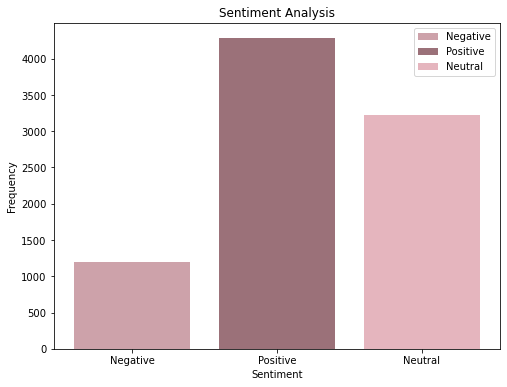

In [17]:
# Define colors for the bar plot
colors = {
    'Positive': '#9b7179',
    'Negative': '#cda2aa',
    'Neutral': '#e5b5be'
}

# Plot a bar graph for sentiment frequency with a legend
plt.figure(figsize=(8, 6))
bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=[colors[label] for label in sentiment_counts.keys()])

# Add legend
for bar, label in zip(bars, sentiment_counts.keys()):
    bar.set_label(label)
plt.legend()

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis')
plt.show()

In [18]:
# Analyzing the most frequently mentioned brands/products
brand_product_counts = df['emotion_in_tweet_is_directed_at'].value_counts().head(10)

# Extracting sentiment counts for each of the top brands/products
top_brands_products = brand_product_counts.index
sentiment_by_brand = df[df['emotion_in_tweet_is_directed_at'].isin(top_brands_products)].groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)

brand_product_counts, sentiment_by_brand


(iPad                               907
 Apple                              638
 iPad or iPhone App                 450
 Google                             410
 iPhone                             287
 Other Google product or service    282
 Android App                         77
 Android                             73
 Other Apple product or service      34
 Name: emotion_in_tweet_is_directed_at, dtype: int64,
 is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 emotion_in_tweet_is_directed_at                                    
 Android                                                        0   
 Android App                                                    0   
 Apple                                                          2   
 Google                                                         1   
 Other Apple product or service                                 0   
 Other Google product or service                                1   
 iPad                             

In [19]:
# Create a pivot table to analyze the sentiment distribution for each top brand/product
sentiment_pivot = df[df['emotion_in_tweet_is_directed_at'].isin(top_brands_products)].pivot_table(index='emotion_in_tweet_is_directed_at', columns='is_there_an_emotion_directed_at_a_brand_or_product', aggfunc='size', fill_value=0)

# Normalize the pivot table to see the percentage distribution of sentiments for each brand/product
sentiment_pivot_percentage = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100

sentiment_pivot, sentiment_pivot_percentage


(is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 emotion_in_tweet_is_directed_at                                    
 Android                                                        0   
 Android App                                                    0   
 Apple                                                          2   
 Google                                                         1   
 Other Apple product or service                                 0   
 Other Google product or service                                1   
 iPad                                                           4   
 iPad or iPhone App                                             0   
 iPhone                                                         1   
 
 is_there_an_emotion_directed_at_a_brand_or_product  Negative emotion  \
 emotion_in_tweet_is_directed_at                                        
 Android                                                            8   
 Android App        

#### Overall Sentiment Distribution

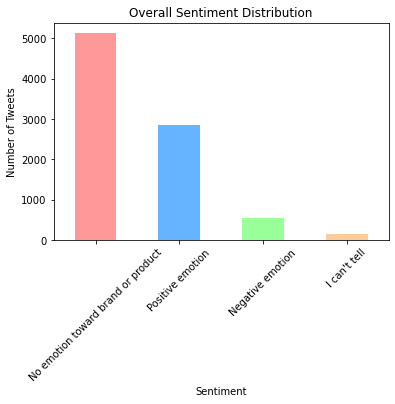

In [20]:
# Sentiment distribution across all tweets
sentiment_counts_all = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_counts_all.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

This bar chart shows the number of tweets expressing each type of sentiment (Positive, Negative, No Emotion, I Can't Tell).

* The most frequent is "No emotion toward brand or product," indicating that many tweets do not express a clear sentiment about a brand or product.

* "Positive emotion" is the second closely, followed by "Negative emotion." This suggests that, among tweets with a clear sentiment, positive emotions are more prevalent than negative ones.

* The "I can't tell" category represents tweets where the sentiment could not be determined.

#### Brand vs Sentiment Distribution

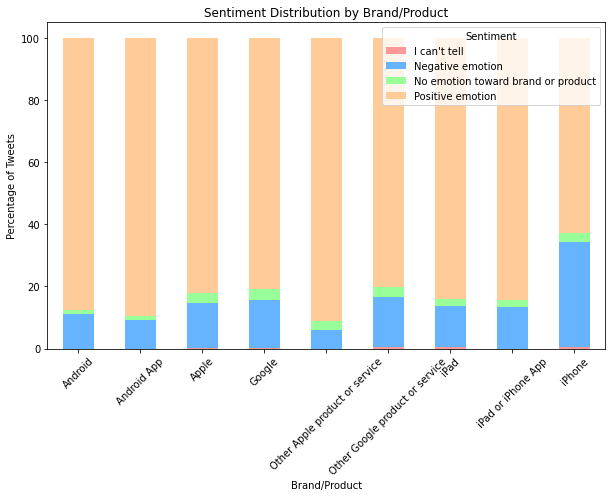

In [21]:
# Top brands/products with sentiment breakdown
sentiment_pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Distribution by Brand/Product')
plt.xlabel('Brand/Product')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

Sentiment Distribution by Brand/Product: 

* This bar chart displays the percentage distribution of sentiments (Positive, Negative, No Emotion, I Can't Tell) for the top brands/products mentioned in the dataset.

* For most brands/products, "Positive emotion" occupies a significant portion, indicating that positive sentiments are more common. For example, "iPad" and "Apple" have high percentages of positive sentiment.

* The "Unknown" category has a high percentage of "No emotion toward brand or product," suggesting that these tweets do not specifically mention any brand or product despite being part of the dataset.

* "Negative emotion" is present but less common than positive sentiment across most brands/products, with notable exceptions like "iPhone," which has a relatively higher percentage of negative sentiment.

#### Sentiment vs. Product Category



In [22]:
# Creating a mapping of products to categories based on brand/product names
category_mapping = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Google': 'Google',
    'iPhone': 'Apple',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google',
    'Other Apple product or service': 'Apple',
    'Unknown': 'Unknown'
}

# Applying the mapping to create a new column for categories
df['category'] = df['emotion_in_tweet_is_directed_at'].map(category_mapping).fillna('Other')

# Calculating sentiment distribution by category
sentiment_by_category = df.groupby(['category', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)

# Normalizing to get percentages
sentiment_by_category_percentage = sentiment_by_category.div(sentiment_by_category.sum(axis=1), axis=0) * 100

sentiment_by_category, sentiment_by_category_percentage


(is_there_an_emotion_directed_at_a_brand_or_product  I can't tell  \
 category                                                           
 Apple                                                          7   
 Google                                                         2   
 Other                                                        142   
 
 is_there_an_emotion_directed_at_a_brand_or_product  Negative emotion  \
 category                                                               
 Apple                                                            371   
 Google                                                           124   
 Other                                                             49   
 
 is_there_an_emotion_directed_at_a_brand_or_product  No emotion toward brand or product  \
 category                                                                                 
 Apple                                                                               62   
 Google      

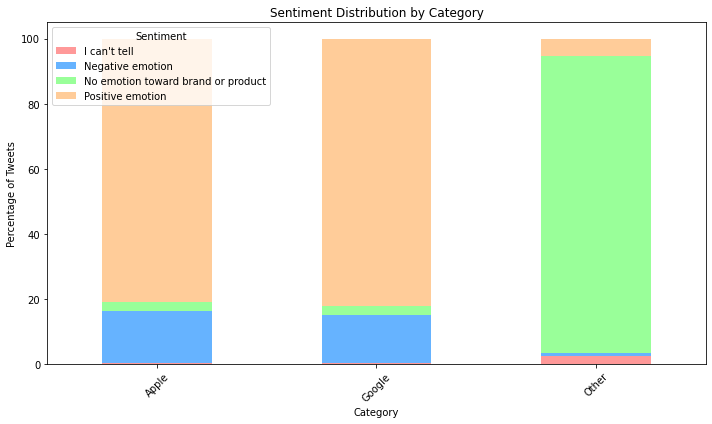

In [23]:
# Visualizing the sentiment distribution by category

# Setting up the color scheme for the chart
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# Plotting the stacked bar chart
sentiment_by_category_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


## Insights

Apple Products: A significant majority of the tweets express positive sentiments (81.02%), with a smaller proportion being negative (16.01%). This indicates a generally favorable public perception.

Google Products: Similar to Apple, the majority of tweets are positive (82.15%), with a smaller percentage being negative (14.66%). This suggests that Google products are also well-regarded.

Unknown Category: Most tweets in this category have no specific emotion directed at a brand/product, which may include generic comments or non-specific discussions.

These findings show a generally positive sentiment towards both Apple and Google products, with a notable proportion of neutral or non-specific tweets.

## Modelling

#### Preprocess Our data for Model Training

In [24]:
# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)

# Tokenization and TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else 0)



In [25]:
#Split our data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model(Logistic Regression Model)

In [26]:
# Baseline model: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

print("Baseline Model - Logistic Regression")
print(classification_report(y_test, y_pred_baseline))
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))


Baseline Model - Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      1171
           1       0.71      0.32      0.44       568

    accuracy                           0.73      1739
   macro avg       0.73      0.63      0.63      1739
weighted avg       0.73      0.73      0.70      1739

Accuracy: 0.7349051178838413


We created our baseline model to work with(Logistic Regression)
Our model is 73.5% accurate meaning out of all sampled tweets,it corrctly classifies 73.5% of these tweets.
Overally, this model can be improved but we use this as a bench mark for the rest of the models

### Model 2:Tuned Model: SVM with Grid Search CV

In [27]:
#from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Initialize the model
svm_model = SVC()

# Initialize GridSearchCV
grid = GridSearchCV(svm_model, param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the model
grid.fit(X_train, y_train)

# Predict using the best model
y_pred_tuned = grid.best_estimator_.predict(X_test)

print("Tuned Model - SVM with GridSearchCV")
print(f"Best Parameters: {grid.best_params_}")
print(classification_report(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))


Fitting 5 folds for each of 32 candidates, totalling 160 fits


Tuned Model - SVM with GridSearchCV
Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.76      0.93      0.83      1171
           1       0.72      0.38      0.50       568

    accuracy                           0.75      1739
   macro avg       0.74      0.66      0.67      1739
weighted avg       0.75      0.75      0.73      1739

Accuracy: 0.7510063254744106


This particular model accounts for 75% accuracy in our model data correctly classifying tweet sentiments 75% correctly which is a decent perfomance but room for improvement is not limited. Balanced metrics for both classes and a fairly good average score quantifies for the model's perfomance.

#### Model 3(Gradient Boosting)

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# Advanced model: Gradient Boosting
advanced_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
advanced_model.fit(X_train, y_train)
y_pred_advanced = advanced_model.predict(X_test)

print("Advanced Model - Gradient Boosting")
print(classification_report(y_test, y_pred_advanced))
print("Accuracy:", accuracy_score(y_test, y_pred_advanced))


Advanced Model - Gradient Boosting
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1171
           1       0.79      0.20      0.32       568

    accuracy                           0.72      1739
   macro avg       0.76      0.59      0.58      1739
weighted avg       0.74      0.72      0.66      1739

Accuracy: 0.7228292121909143


This model accounts for 72% accuracy in our dataset. major room for improvement with overall metrics to reduce oversampling in our model.

#### Model 4(Random Forest Model)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Model")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Model
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1171
           1       0.70      0.38      0.49       568

    accuracy                           0.74      1739
   macro avg       0.73      0.65      0.66      1739
weighted avg       0.74      0.74      0.72      1739

Accuracy: 0.7441058079355952


This random forest model above accounts for approximately 74.4% accuracy in our data with a slightly balanced precision but still with room for improvement

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict using the best model
y_pred_rf_tuned = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned model
print("Tuned Random Forest Model")
print(classification_report(y_test, y_pred_rf_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_tuned))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Random Forest Model
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1171
           1       0.62      0.48      0.54       568

    accuracy                           0.74      1739
   macro avg       0.70      0.67      0.68      1739
weighted avg       0.72      0.74      0.73      1739

Accuracy: 0.7354801610120759
